### Test the Van Leeuwen Mapping in case of Mean Field Auxiliary field

#### Imports

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
from scipy.sparse.linalg import eigsh,expm
import qutip
import os
from datetime import datetime

import torch
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
from typing import List
import os


import numpy as np
from scipy.ndimage import convolve1d

def finite_diff_scipy(f, dt, axis=-1):
    coeffs = np.array([1/280, -4/105, 1/5, -4/5, 4/5, -1/5, 4/105, -1/280])
    df_dt = convolve1d(f, coeffs, axis=axis, mode='nearest') / dt
    return df_dt


def generate_smooth_gaussian_noise(
    time: np.ndarray,
    tau: float,
    tf: float,
    mean: float,
    sigma: float,
    min_range: float,
    max_range: float,
    shift: float,
):
    a_omegas = np.random.normal(mean, sigma, size=time.shape[0])
    omegas = np.linspace(0, time.shape[0] * 2 * np.pi / tf, time.shape[0])
    driving = np.zeros(time.shape[0])

    for tr in range(time.shape[0]):
        if omegas[tr] < 2 * np.pi / tau:
            driving = driving + a_omegas[tr] * np.cos(omegas[tr] * time)

        else:
            break

    max_driving = np.max(driving)
    min_driving = np.min(driving)

    old_interval = max_driving - min_driving
    driving = (
        (driving - min_driving) * (max_range - min_range) / old_interval
        + min_range
        + shift
    )

    return driving


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t/self.dt)<self.h.shape[0]:
            return self.h[int(t / self.dt), self.idx]
        else:
            return self.h[-1, self.idx]
    def get_the_field(
        self,
    ):
        return self.h
    

def second_derivative_7point(arr, dt):
    """
    Computes the second-order derivative using a 7-point finite difference stencil 
    along the time axis of a 2D array.

    Parameters:
        arr (numpy.ndarray): Input 2D array with shape [time, space].
        dt (float): Time step between successive data points.

    Returns:
        numpy.ndarray: Second derivative array with the same shape as input.
    """

    # Coefficients for the 7-point stencil (centered)
    coeffs = np.array([1/90, -27/180, +27/18, -49/18, +27/18, -27/180, 1/90 ])

    # Initialize output array
    d2_arr = np.zeros_like(arr)

    # Apply stencil only on valid indices (avoid boundaries)
    for i in range(3, arr.shape[0] - 3):
        d2_arr[i, :] = (
            coeffs[0] * arr[i - 3, :] +
            coeffs[1] * arr[i - 2, :] +
            coeffs[2] * arr[i - 1, :] +
            coeffs[3] * arr[i, :] +
            coeffs[4] * arr[i + 1, :] +
            coeffs[5] * arr[i + 2, :] +
            coeffs[6] * arr[i + 3, :]
        )

    # Convert to second derivative by dividing by dt^2
    d2_arr /= dt ** 2

    return d2_arr

#### Make the $h_{eff}(t)$ field for the Mean Field Auxiliary system

In [70]:
# fix the stochastic field

rate_mean=1.5
rate_sigma=1.5

amplitude_max=2.
amplitude_min=0.

rate_cutoff = 10
    #rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
rate=rate_mean+rate_sigma*np.random.normal(size=rate_cutoff)
delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))


# sampling the initial state (if the option is required)

p=np.random.uniform(0.,0.5)


In [71]:
# hyperparameters

nbatch = 1

batch_size = 1
l = 8
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = -1
# omega auxiliary field
omega = 1



steps =600
tf =60.0
time = np.linspace(0.0, tf, steps)


# z_qutip_tot = np.zeros((nbatch * nbatch * batch_size, steps, l))
z_qutip_tot = np.zeros(( batch_size , steps, l))
h_tot = np.zeros(( batch_size , steps, l))
entanglement_tot = np.zeros(( batch_size , steps))
entanglement_half_tot = np.zeros(( batch_size , steps))


ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=True,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    obs.append(z_op.qutip_op)
    
hi=np.zeros((time.shape[0], l))

for batch_idx in trange(batch_size):





    

    h = (
        delta[:, None, None]
        * ((np.cos(np.pi+time[None, :, None] * rate[:, None, None])+1))
        + hi
    )
    h = np.average(h, axis=0)



    hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

    eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
        eigvals=1
    )
    psi0 = psi0[
        0
    ]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

    # we can build our own psi0
    # psi_plus=qutip.basis(2,0)
    # print(psi_plus)
    # psi_minus=qutip.sigmam()*qutip.basis(2,0)
    # print(psi_minus)

    
    # for i in range(l):
    #     if i==0:
    #         psi0=psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus
    #     else:
    #         psi0=qutip.tensor(psi0,psi_plus*np.sqrt(p)+np.sqrt(1-p)*psi_minus)
            
    z_value=[]
    for i in range(l):
        z_value.append((psi0.conj().trans() * obs[i] * psi0)[0,0])



    hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

    for i in range(l):
        drive_z = Driving(
            h=h,
            dt=time[1] - time[0],
            idx=i,
        )

        hamiltonian.append([obs[i], drive_z.field])

    # evolution and

    output = qutip.sesolve(hamiltonian, psi0, time,)

    z_exp = np.zeros((steps, l))
    entanglement=[]
    entanglement_half=[]
    for t,state in enumerate(output.states):
        
        for r in range(l):
            z_exp[t, r] = (state.dag() * obs[r] * state)[0,0]
            
        rho=state.ptrace([0])
        rho_half=state.ptrace(np.arange(l//2))
        entanglement.append(qutip.entropy_vn(rho))
        entanglement_half.append(qutip.entropy_vn(rho_half))
        
            #current_exp[:,r]=output.expect[r+l]
    entanglement=np.asarray(entanglement)
    entanglement_half=np.asarray(entanglement_half)

    # Current derivative
    current_exp=np.gradient(z_exp, time, axis=0)

    current_derivative = np.gradient(current_exp, time, axis=0)

    z_qutip_tot[batch_idx]=z_exp
    entanglement_tot[batch_idx]=entanglement
    entanglement_half_tot[batch_idx]=entanglement_half
    h_tot[batch_idx]=h



  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_714772/1949991005.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  z_exp[t, r] = (state.dag() * obs[r] * state)[0,0]
100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


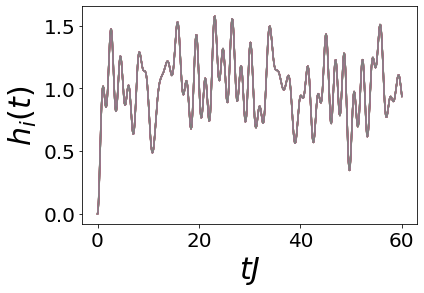

[1.00969096 1.00969096 1.00969096 1.00969096 1.00969096 1.00969096
 1.00969096 1.00969096]


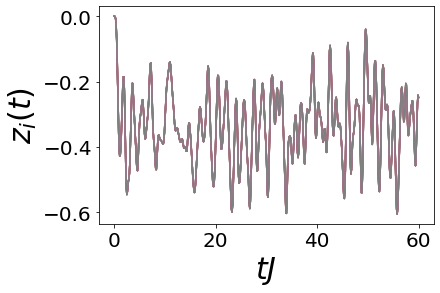

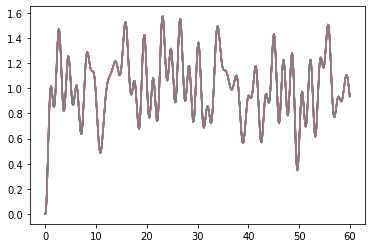

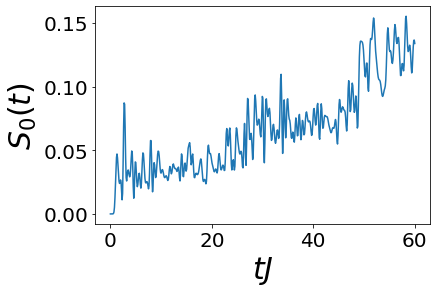

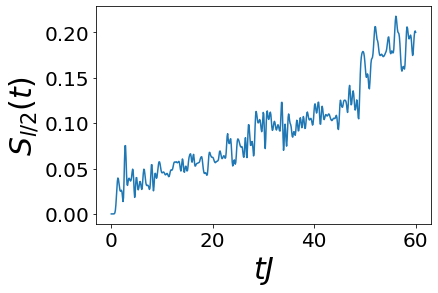

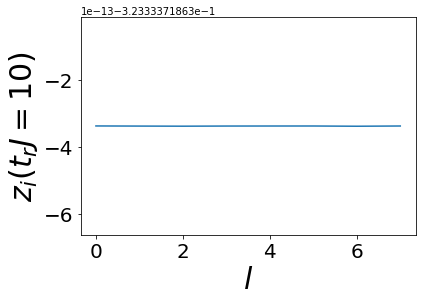

In [72]:

plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$h_i(t)$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.plot(time,np.average(h_tot,axis=0))
plt.show()

print(np.average(h,axis=0))

plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$z_i(t)$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.plot(time,np.average(z_qutip_tot,axis=0))
#plt.plot(time,z_qutip_tot[0])
plt.show()

plt.plot(time,h_tot[0])
plt.show()



plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$S_{0}(t)$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.plot(time,np.average(entanglement_tot,axis=0)/np.log(2))
plt.show()

plt.xlabel(r'$tJ$',fontsize=30)
plt.ylabel(r'$S_{l/2}(t)$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.plot(time,np.average(entanglement_half_tot,axis=0))
plt.show()


plt.xlabel('$l$',fontsize=30)
plt.ylabel('$z_i (t_r J=10)$',fontsize=30)
plt.tick_params(which='major',labelsize=20)
plt.plot(z_exp[100])
plt.show()

In [10]:
np.savez('data/entanglement_l_10',entropy_0=np.average(entanglement_tot,axis=0),entropy_l2=np.average(entanglement_half_tot,axis=0))


#### Test for the effective field

set the hyperparameters

Initialize the state

(600, 8)
(6000, 8)


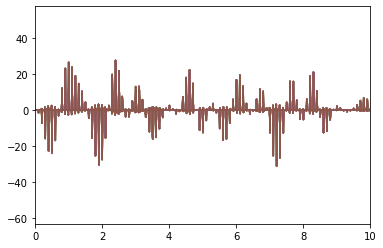

In [74]:
from scipy.interpolate import interp1d

psi=np.zeros((2,l))
psi[0] = np.sqrt((1 + z_exp[0]) / 2)
psi[1] = np.sqrt((1 - z_exp[0]) / 2)


# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


nsteps_tddft=6000
time_tddft=np.linspace(0,tf,nsteps_tddft)
hi=np.zeros((time_tddft.shape[0], l))


dt=time_tddft[1]-time_tddft[0]
print(z_exp.shape)

f=interp1d(time,z_exp,axis=0)
z_tddft=f(time_tddft)

current_tddft=np.gradient(z_tddft,time_tddft,axis=0)
current_derivative_tddft=np.gradient(current_tddft,time_tddft,axis=0)

plt.plot(time_tddft,current_derivative_tddft)

current_derivative_tddft=second_derivative_7point(z_tddft,dt)
print(current_derivative_tddft.shape)

plt.plot(time_tddft,current_derivative_tddft[:,])

plt.xlim([0,10])
plt.show()

#### Evolution

In [75]:
z_reconstruction=np.zeros((nsteps_tddft,l))
x_ave_evolution=np.zeros((nsteps_tddft,l))
nonlinear_evolution=np.zeros_like(x_ave_evolution)
for i in trange(nsteps_tddft):
    psi_r=psi.copy()
    for f in range(1):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
        z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
        
        #pbc
        nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega+1.e-10
        
        #obc
        # shift_plus=np.zeros(l)
        # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
        # shift_minus=np.zeros(l)
        # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
        # #print(shift_minus,shift_plus)
        # nonlinear_term=j*(shift_plus+shift_minus)+omega+10**-10
        h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+1.e-10)
        #print('heff_shape=',h_eff.shape)
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
        psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
        
    psi=np.einsum('lab,bl->al',exp_h_t,psi)
    psi=psi/np.linalg.norm(psi,axis=0)
    
    
    z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    x_ave_evolution[i]=x_ave
    nonlinear_evolution[i]=nonlinear_term

f=interp1d(time_tddft,z_reconstruction,axis=0)
z_reconstruction=f(time)


# we need to build up the Auxiliar Time dependent evolution by using Exact diagonalization

  0%|          | 0/6000 [00:00<?, ?it/s]/tmp/ipykernel_714772/3293917117.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_714772/3293917117.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  x_ave_evolution[i]=x_ave
/tmp/ipykernel_714772/3293917117.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  nonlinear_evolution[i]=nonlinear_term
100%|██████████| 6000/6000 [00:08<00:00, 670.49it/s]


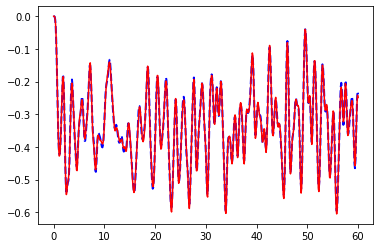

In [76]:
for i in range(1):
    plt.plot(time,z_reconstruction[:,i],color='blue',linestyle='--',linewidth=2)
    plt.plot(time,z_exp[:,i],color='red')
    plt.show()



#### Analysis of the time step on the stability of the Time Dependent DFT

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 8/8 [00:00<00:00, 395.03it/s]

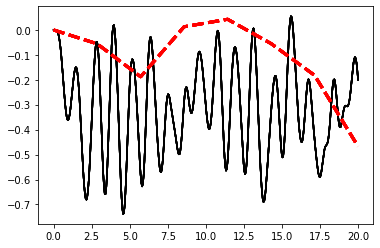

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


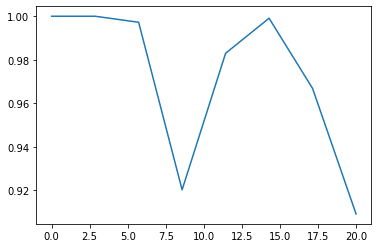

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


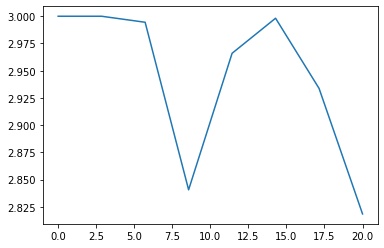

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 16/16 [00:00<00:00, 405.13it/s]


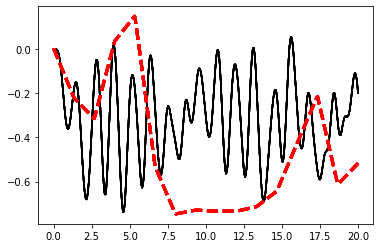

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


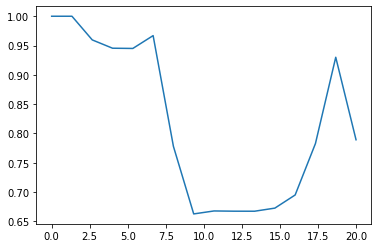

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


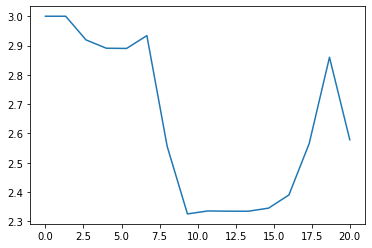

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 32/32 [00:00<00:00, 384.36it/s]


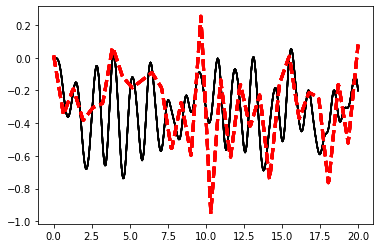

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


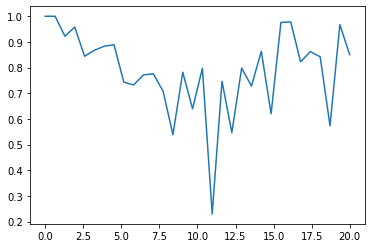

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


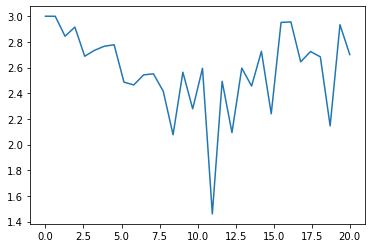

  0%|          | 0/64 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 64/64 [00:00<00:00, 428.92it/s]


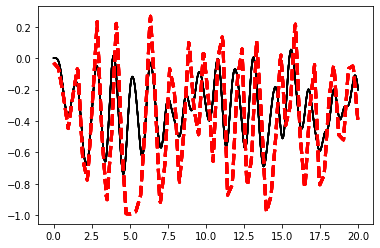

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


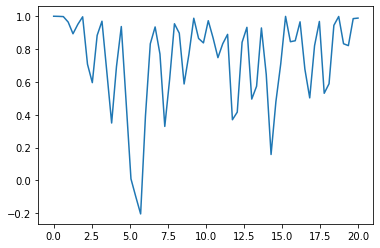

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


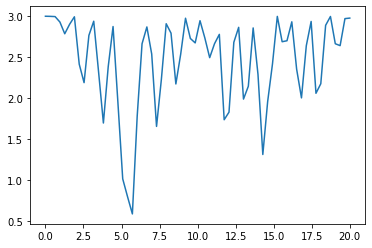

  0%|          | 0/128 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 128/128 [00:00<00:00, 496.24it/s]


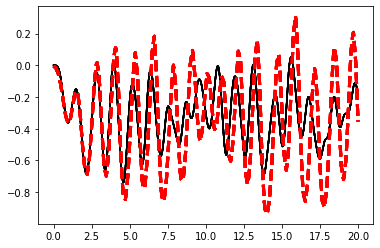

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


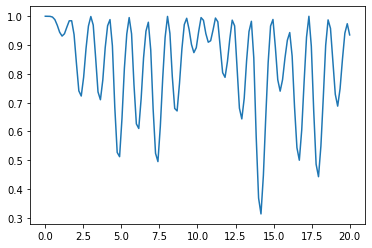

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


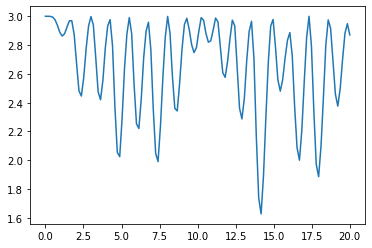

  0%|          | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 256/256 [00:00<00:00, 427.51it/s]


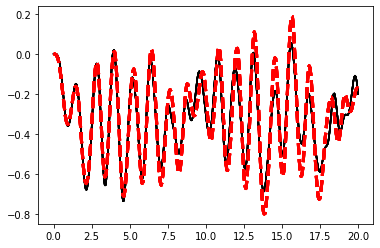

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


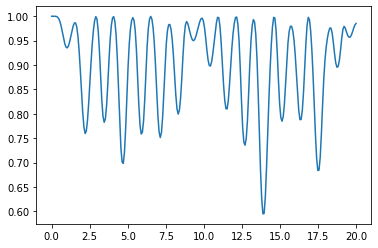

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


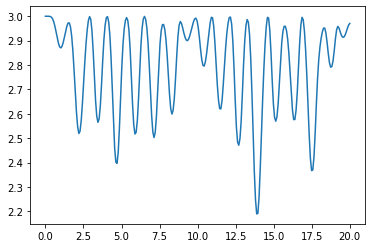

  0%|          | 0/512 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 512/512 [00:00<00:00, 564.33it/s]


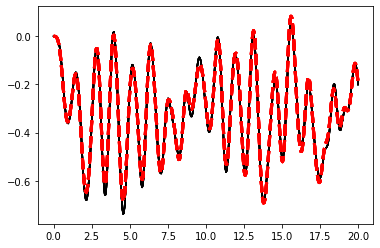

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


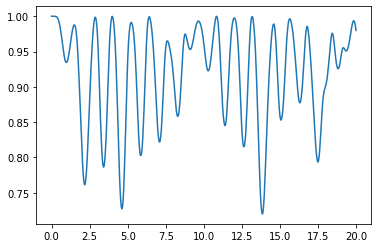

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


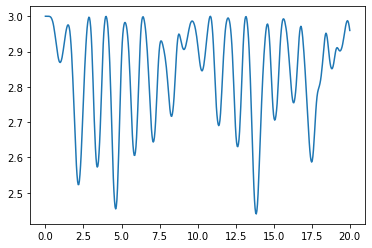

  0%|          | 0/1024 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 1024/1024 [00:01<00:00, 565.05it/s]


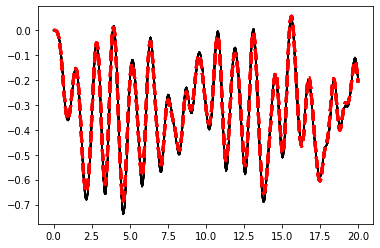

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


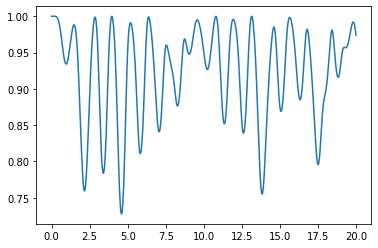

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


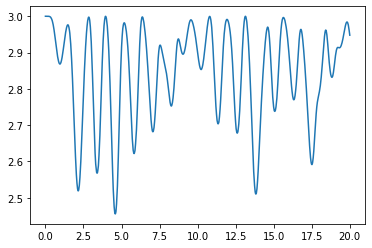

  0%|          | 0/2048 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 2048/2048 [00:03<00:00, 572.19it/s]


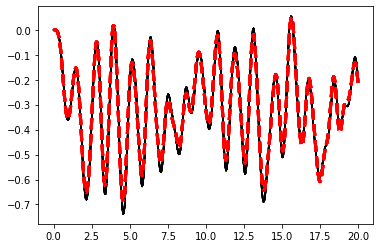

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


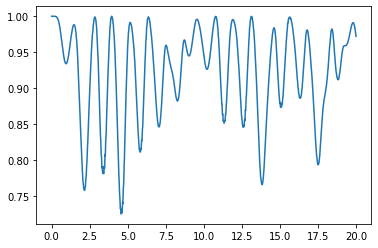

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


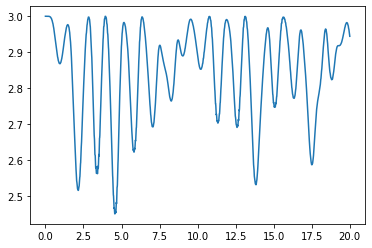

  0%|          | 0/4096 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 4096/4096 [00:07<00:00, 523.33it/s]


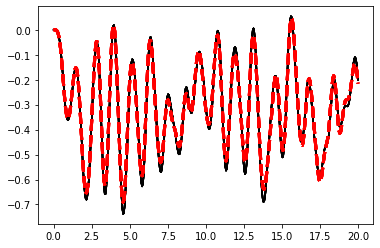

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


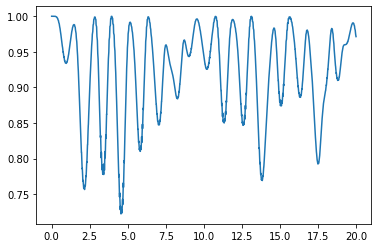

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


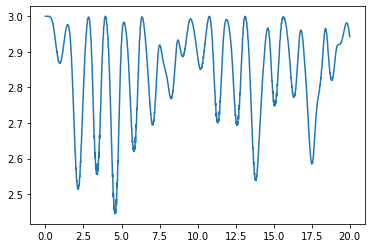

  0%|          | 0/8192 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 8192/8192 [00:14<00:00, 584.29it/s]


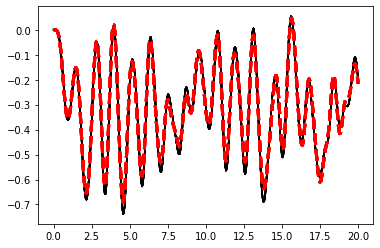

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


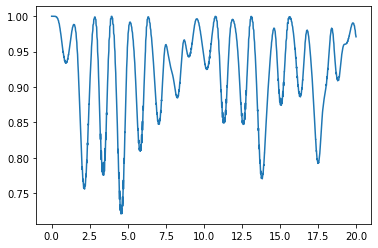

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


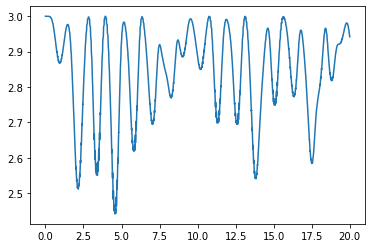

  0%|          | 0/16384 [00:00<?, ?it/s]/tmp/ipykernel_2003151/2129513324.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 16384/16384 [00:27<00:00, 598.21it/s]


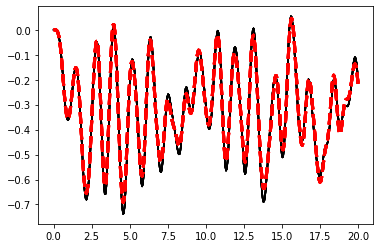

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


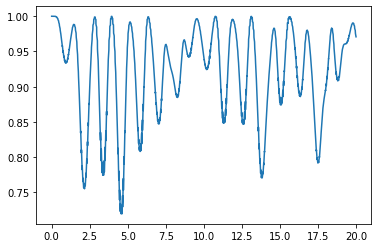

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


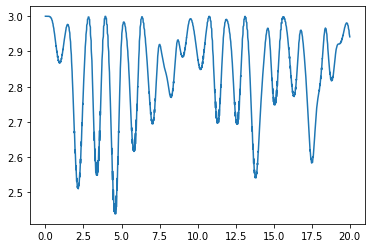

In [22]:
from scipy.interpolate import interp1d




steps=2**np.arange(3,15)
dzs=[]
for nsteps_tddft in steps:

    time_tddft=np.linspace(0,tf,nsteps_tddft)
    hi=np.zeros((time_tddft.shape[0], l))


    dt=time_tddft[1]-time_tddft[0]
    
    f=interp1d(time,z_exp,axis=0)
    z_tddft=f(time_tddft)

    current_tddft=np.gradient(z_tddft,time_tddft,axis=0)
    current_derivative_tddft=np.gradient(current_tddft,time_tddft,axis=0)

    z_reconstruction=np.zeros((nsteps_tddft,l))
    
    psi=np.zeros((2,l))
    psi[0] = np.sqrt((1 + z_exp[0]) / 2)
    psi[1] = np.sqrt((1 - z_exp[0]) / 2)


    # build up the operators
    x_op=np.array([[0.,1.],[1.,0]])
    z_op=np.array([[1.,0.],[0.,-1.]])
    xs=[]
    nlt=[]
    for i in trange(nsteps_tddft):
        psi_r=psi.copy()
        for f in range(1):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
            z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
            xs.append(x_ave)
            #pbc
            nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega#+10**-10
            nlt.append(nonlinear_term)
            #obc
            # shift_plus=np.zeros(l)
            # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
            # shift_minus=np.zeros(l)
            # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
            # #print(shift_minus,shift_plus)
            # nonlinear_term=j*(shift_plus+shift_minus)+omega+10**-10
            h_eff=(0.25*current_derivative_tddft[i]/(nonlinear_term*x_ave)+z_tddft[i]*nonlinear_term/x_ave)
            #print('heff_shape=',h_eff.shape)
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            
            #print(exp_h_t)    
            #psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
            #psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
            
            psi_nonlinearity=crank_nicolson_algorithm(hamiltonian_t,psi=psi_r,dt=dt)
            # the CN algorithm requires an adjustment in the nonlinear term, we fix the first order self consistent step
            x_nonlinearity=np.einsum('al,ab,bl->l',np.conj(psi_nonlinearity),x_op,psi_nonlinearity)
            nonlinear_term_plus=np.abs(j)*(np.roll(x_nonlinearity,shift=1)+np.roll(x_nonlinearity,shift=-1))+omega#+10**-10
            h_eff_plus=(0.25*current_derivative_tddft[i]/nonlinear_term_plus+z_tddft[i]*nonlinear_term_plus)/(x_ave+10**-10)
            hamiltonian_t_plus=nonlinear_term_plus[:,None,None]*x_op[None,:,:]+h_eff_plus[:,None,None]*z_op[None,:,:]
            psi_t=crank_nicolson_algorithm(hamiltonian_t_plus,psi=psi_r,dt=dt)
            
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        
        z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
        

    f=interp1d(time_tddft,z_reconstruction,axis=0)
    z_reconstruction=f(time)
    plt.plot(time,z_exp,color='black')
    plt.plot(time,z_reconstruction,color='red',linestyle='--',linewidth=3)
    plt.show()
    
    plt.plot(time_tddft,np.asarray(xs)[:,0])
    plt.show()
    
    plt.plot(time_tddft,np.asarray(nlt)[:,0])
    plt.show()
    
    dzs.append(np.average(np.abs(z_exp-z_reconstruction)))
    
    

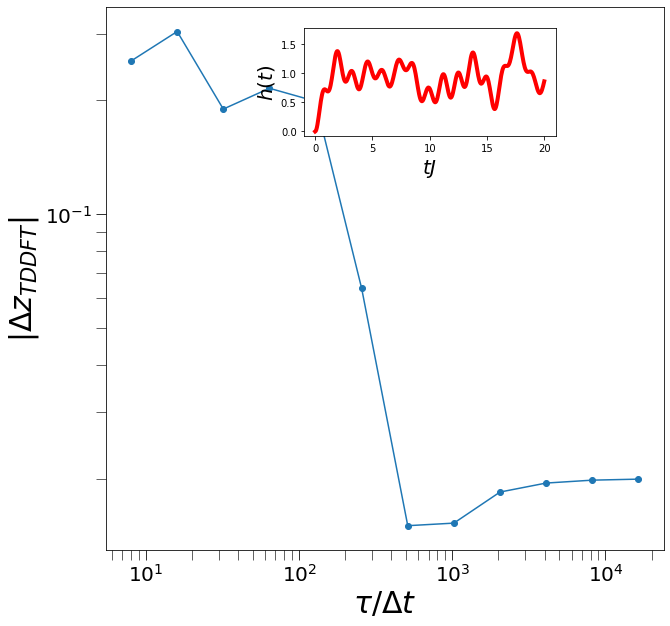

ValueError: x and y must have same first dimension, but have shapes (400,) and (8,)

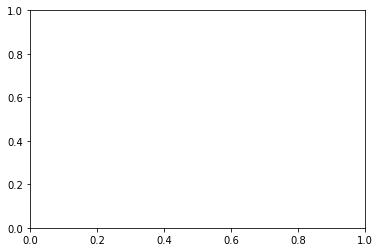

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(steps,dzs)
ax.scatter(steps,dzs)
ax.set_xlabel(r'$\tau/\Delta t $',fontsize=30)
ax.set_ylabel(r'$ | \Delta z_{TDDFT}|$',fontsize=30)
ax.tick_params(which='major',labelsize=20,length=6,size=10)
ax.tick_params(which='minor',length=3,size=10,labelsize=15)
ax.loglog()
inset_ax = fig.add_axes([0.4, 0.7, 0.35, 0.15]) # [x_position, y_position, width, height]
inset_ax.plot(time,h[:,0],color='red',linewidth=4)
inset_ax.set_ylabel(r'$h(t)$',fontsize=20)
inset_ax.set_xlabel(r'$tJ$',fontsize=20)
plt.show()

plt.plot(time,nonlinear_term)
plt.show()



### Check the dataset performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
from scipy.sparse.linalg import eigsh,expm
import qutip
import os
from datetime import datetime

import torch
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
from typing import List
import os


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Data info

In [6]:
data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/dataset_2025-02-01_16-31.npz')
comments=data['comments']
print(data['comments'])
print(data['info'])

fixed Initial state ground state, with a diagonostic is False dataset. 2nd order time derivative with9-points formula
xx-z-x model with omega=1.0, coupling=-1.0 external field with rate mean=1.5 and rate sigma=1.5 amplitude max=2.0 amplitude min=0.0 tf=20 steps=800 l variable ndata=10000 initial state option=True pbc=True


Data values

In [7]:


z=data['z']
z_auxiliary=data['z_auxiliary']
h_eff=data['h_eff']
h=data['h']
time=data['time']

print(h.shape)
print(z.shape)
    

(10000, 201, 1)
(10000, 200, 1)


Visualization

(10000,)


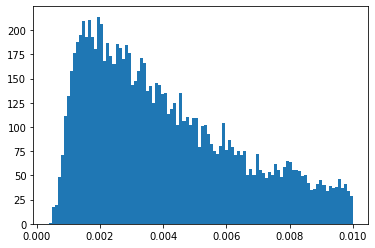

(10000, 200, 1)


In [8]:

    
dz=np.average(np.abs(z-z_auxiliary),axis=(-1,-2))
print(dz.shape)
plt.hist(dz,bins=100,)
plt.show()

print(z[dz<0.01].shape)
    


Check the $h_{eff}$ reconstruction

In [12]:
from scipy.interpolate import interp1d
l=8
idx=np.random.randint(0,100)
j=-1
omega=1

psi=np.zeros((2,l))
psi[0] = np.sqrt((1 + z[idx,0]) / 2)
psi[1] = np.sqrt((1 - z[idx,0]) / 2)


# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


nsteps_tddft=2000
time_tddft=np.linspace(0,20,nsteps_tddft)
hi=np.zeros((time_tddft.shape[0], l))

dt=time_tddft[1]-time_tddft[0]

print('dt=',dt)
print(time.shape,h_eff.shape)
f=interp1d(time,h_eff[idx,1:,0],axis=0)
h_eff_tddft=f(time_tddft)
z_reconstruction=np.zeros((nsteps_tddft,l))
x_ave_evolution=np.zeros((nsteps_tddft,l))
nonlinear_evolution=np.zeros_like(x_ave_evolution)
print('h_eff tddft=',h_eff_tddft.shape)
for i in trange(nsteps_tddft):
    psi_r=psi.copy()
    x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
    z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
    

    nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega+10**-10
    #print('heff_shape=',h_eff.shape)
    hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+np.ones(l)[:,None,None]*h_eff_tddft[i,None,None,None]*z_op[None,:,:]
    exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
    for r in range(l):
        exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
    #print(exp_h_t)    
    psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
    psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
    
    psi=np.einsum('lab,bl->al',exp_h_t,psi)
    psi=psi/np.linalg.norm(psi,axis=0)
    
    
    z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    x_ave_evolution[i]=x_ave
    nonlinear_evolution[i]=nonlinear_term

f=interp1d(time_tddft,z_reconstruction,axis=0)
z_reconstruction=f(time)


# we need to build up the Auxiliar Time dependent evolution by using Exact diagonalization

dt= 0.010005002501250625
(200,) (100, 201, 1)
h_eff tddft= (2000,)


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1004388/3083412283.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_1004388/3083412283.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  x_ave_evolution[i]=x_ave
/tmp/ipykernel_1004388/3083412283.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  nonlinear_evolution[i]=nonlinear_term
100%|██████████| 2000/2000 [00:03<00:00, 645.87it/s]


Compute $h_{eff}$ using that particular z

In [13]:
from scipy.interpolate import interp1d

psi=np.zeros((2,l))
psi[0] = np.sqrt((1 + z[idx,0]) / 2)
psi[1] = np.sqrt((1 - z[idx,0]) / 2)


# build up the operators
x_op=np.array([[0.,1.],[1.,0]])
z_op=np.array([[1.,0.],[0.,-1.]])


hi=np.zeros((time_tddft.shape[0], l))


dt=time_tddft[1]-time_tddft[0]

f=interp1d(time,z[idx],axis=0)
z_tddft=f(time_tddft)

#current_derivative_tddft=second_derivative_7point(z_tddft,dt)
current_tddft=np.gradient(z_tddft,time_tddft,axis=0)
current_derivative_tddft=np.gradient(current_tddft,time_tddft,axis=0)




z_reconstruction_check=np.zeros((nsteps_tddft,l))
x_ave_evolution=np.zeros((nsteps_tddft,l))
h_eff_check_evolution=np.zeros((nsteps_tddft,l))

nonlinear_evolution=np.zeros_like(x_ave_evolution)
for i in trange(nsteps_tddft):
    psi_r=psi.copy()
    for f in range(1):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
        z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
        
        #pbc
        nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega+10**-10
        
        h_eff_check=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
        h_eff_check_evolution[i]=h_eff_check
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_check[:,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
        psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
        
    psi=np.einsum('lab,bl->al',exp_h_t,psi)
    psi=psi/np.linalg.norm(psi,axis=0)
    
    
    z_reconstruction_check[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    x_ave_evolution[i]=x_ave
    nonlinear_evolution[i]=nonlinear_term

f=interp1d(time_tddft,z_reconstruction_check,axis=0)
z_reconstruction_check=f(time)

f=interp1d(time_tddft,h_eff_check_evolution,axis=0)
h_eff_check_evolution=f(time)





  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1004388/4048085120.py:56: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction_check[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_1004388/4048085120.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  h_eff_check_evolution[i]=h_eff_check
/tmp/ipykernel_1004388/4048085120.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  x_ave_evolution[i]=x_ave
/tmp/ipykernel_1004388/4048085120.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  nonlinear_evolution[i]=nonlinear_term
100%|██████████| 2000/2000 [00:03<00:00, 624.13it/s]


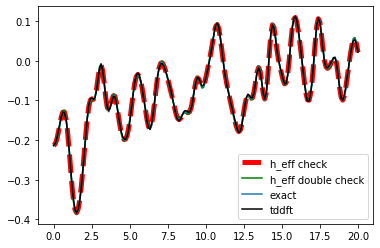

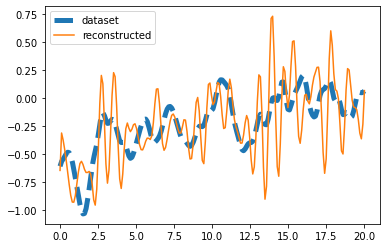

In [14]:
plt.plot(time,z_reconstruction[:,0],color='red',label='h_eff check',linewidth=5,linestyle='--')
plt.plot(time,z_reconstruction_check[:,0],color='green',label='h_eff double check')
plt.plot(time,z[idx,:,0],label='exact')
plt.plot(time,z_auxiliary[idx,:,0],color='black',label='tddft')
plt.legend()
plt.show()

plt.plot(time_tddft,h_eff_tddft[:],label='dataset',linewidth='5',linestyle='--')
plt.plot(time,h_eff_check_evolution[:,0],label='reconstructed')
plt.legend()
plt.show()

(Optional) Save a new training dataset

In [5]:
np.savez(f'data/dataset_h_eff/new_analysis_xxzx_model/pbc_training_dataset_fixed_initial_state_time_5_nsteps_50_ndata_{z[dz<0.01].shape[0]}.npz',info='variable initial state, cut from an original dataset removing all the samples that deviates from the original magnetization from dz=0.01',comments=comments,h=h[dz<0.01,:51],h_eff=h_eff[dz<0.01,:51])

### Analysis of the time step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
from scipy.sparse.linalg import eigsh,expm
import qutip
import os
from datetime import datetime

import torch
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
from typing import List
import os

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [12]:
file_names=['dataset_2024-10-26_13-54.npz','dataset_2024-10-26_18-46.npz','dataset_2024-10-25_19-23.npz','dataset_2024-10-26_18-50.npz','dataset_2024-10-25_19-31.npz',]


errors=[]
time_steps=np.array([200,400,600,800,1000])
dt=10/time_steps
for name in file_names:
    
    data=np.load('data/dataset_h_eff/new_analysis_xxzx_model/'+name)
    print(data['info'])
    print(data['comments'])
    
    z=data['z'][:100]
    z_auxiliary=data['z_auxiliary'][:100]
    
    dz=np.average(np.abs(z-z_auxiliary))
    errors.append(dz)
    

    
    
    

xx-z-x model with omega=1.0, coupling= 1.0 external field with rate max=3.0 and rate min=0.1 amplitude max=4.0 amplitude min=-4.0 tf=10 steps=200 l variable ndata=100 initial state option=True pbc=False
variable Initial state
xx-z-x model with omega=1.0, coupling= 1.0 external field with rate max=3.0 and rate min=0.1 amplitude max=4.0 amplitude min=-4.0 tf=10 steps=400 l variable ndata=100 initial state option=True pbc=False
variable Initial state
xx-z-x model with omega=1.0, coupling= 1.0 external field with rate max=3.0 and rate min=0.1 amplitude max=4.0 amplitude min=-4.0 tf=10 steps=600 l variable ndata=5000 initial state option=True pbc=False
variable Initial state
xx-z-x model with omega=1.0, coupling= 1.0 external field with rate max=3.0 and rate min=0.1 amplitude max=4.0 amplitude min=-4.0 tf=10 steps=800 l variable ndata=100 initial state option=True pbc=False
variable Initial state
xx-z-x model with omega=1.0, coupling= 1.0 external field with rate max=3.0 and rate min=0.1 am

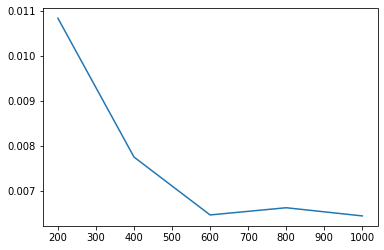

In [13]:
plt.plot(time_steps,errors)
plt.show()

### Test the Transfer Learning of the neural network

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft, ifft
from scipy.sparse.linalg import eigsh,expm
import qutip
import os
from datetime import datetime

import torch
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver

import qutip
from typing import List
import os



def generate_smooth_gaussian_noise(
    time: np.ndarray,
    tau: float,
    tf: float,
    mean: float,
    sigma: float,
    min_range: float,
    max_range: float,
    shift: float,
):
    a_omegas = np.random.normal(mean, sigma, size=time.shape[0])
    omegas = np.linspace(0, time.shape[0] * 2 * np.pi / tf, time.shape[0])
    driving = np.zeros(time.shape[0])

    for tr in range(time.shape[0]):
        if omegas[tr] < 2 * np.pi / tau:
            driving = driving + a_omegas[tr] * np.cos(omegas[tr] * time)

        else:
            break

    max_driving = np.max(driving)
    min_driving = np.min(driving)

    old_interval = max_driving - min_driving
    driving = (
        (driving - min_driving) * (max_range - min_range) / old_interval
        + min_range
        + shift
    )

    return driving


class Driving:
    def __init__(self, h: np.array, idx: int, dt: float) -> None:
        self.h = h
        # self.tf=tf
        self.idx: int = idx
        self.dt: float = dt

    def field(self, t: float, args):
        if int(t/self.dt)<self.h.shape[0]:
            return self.h[int(t / self.dt), self.idx]
        else:
            return self.h[-1, self.idx]
    def get_the_field(
        self,
    ):
        return self.h

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Make the $h_{eff}(t)$ field for the Mean Field Auxiliary system

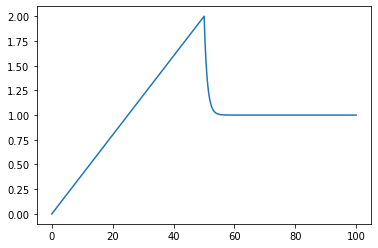

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


real ground state energy= -16.0


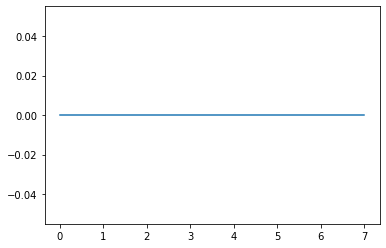

In [50]:
# hyperparameters

nbatch = 1

batch_size = 500
l = 8
# rates = [0.1, 0.5, 0.8, 1.0]

# j coupling
j = -1
# omega auxiliary field
omega = 1

rate_max=2.
rate_min=0.1

amplitude_max=2.
amplitude_min=0

steps = 1000
tf =100.0
time = np.linspace(0.0, tf, steps)

info=f'xx-z-x model with omega={omega:.1f}, coupling={j: .1f} external field with rate max={rate_max:.1f} and rate min={rate_min:.1f} amplitude max={amplitude_max:.1f} amplitude min={amplitude_min:.1f} tf={tf:.0f} steps={steps} l={l} ndata={batch_size}'
comments='different initial state, global magnetization and we are lowering the amplitude'
# z_qutip_tot = np.zeros((nbatch * nbatch * batch_size, steps, l))
z_qutip_tot = np.zeros(( batch_size , steps, l))
h_eff_tot = np.zeros(( batch_size , steps, l))
h_tot = np.zeros(( batch_size , steps, l))
current_qutip_tot = np.zeros(( batch_size , steps, l))
current_derivative_tot = np.zeros(( batch_size , steps, l))
x_sp_tot = np.zeros(( batch_size , steps, l))

ham0 = SpinHamiltonian(
    direction_couplings=[("x", "x")],
    pbc=True,
    coupling_values=[j],
    size=l,
)

hamExtX = SpinOperator(index=[("x", i) for i in range(l)], coupling=[omega] * l, size=l)

obs: List[qutip.Qobj] = []
current_obs: List[qutip.Qobj] = []

for i in range(l):
    z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
    # print(f"x[{i}]=", x.qutip_op, "\n")
    #pbc
    current = SpinOperator(
        index=[("x", (i - 1) % l, "y", i), ("y", i, "x", (i + 1) % l)],
        coupling=[2 * j, 2 * j],
        size=l,
    )
    #obc
    if i-1 >=0 and i+1<=l-1:
        current = SpinOperator(
            index=[("x", (i - 1) , "y", i), ("y", i, "x", (i + 1) )],
            coupling=[2 * j, 2 * j],
            size=l,
        )

    obs.append(z_op.qutip_op)
    current_obs.append(current.qutip_op)
    
    


# rate = np.random.uniform(0.3, 1.0)

rate_cutoff = 30
rate=np.random.uniform(rate_min,rate_max,size=rate_cutoff)
delta = np.random.uniform(amplitude_min,amplitude_max,size=(rate_cutoff))

h_initial=2.
h_final=1.
gamma=1.
# first part linear ramp and then quench
t_interval_quench=500
h_ramp=h_initial*time/time[t_interval_quench]
h_ramp[t_interval_quench:]=0.
h_quench=np.exp(-gamma*(time[:]-time[t_interval_quench]))*h_initial+(h_final)*(1-np.exp(-gamma*(time[:]-time[t_interval_quench])))
#h_quench=h_final*np.sin(gamma*(time-time[t_interval_quench]))+h_initial
h_quench[:t_interval_quench]=0.
h=(h_ramp+h_quench)[:,None]*np.ones(l)[None,:]

plt.plot(time,h[:,0])
plt.show()

hamExtZ = SpinOperator(index=[("z", i) for i in range(l)], coupling=h[0], size=l)

eng, psi0 = (ham0.qutip_op + hamExtZ.qutip_op + hamExtX.qutip_op).eigenstates(
    eigvals=1
)
psi0 = psi0[
    0
]  # qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

# we can build our own psi0
# psi_plus=qutip.basis(2,0)
# print(psi_plus)
# psi_minus=qutip.sigmam()*qutip.basis(2,0)
# print(psi_minus)

# p_i=np.random.uniform(0.,0.5,size=(l))

# for i in range(l):
#     if i==0:
#         psi0=psi_plus*np.sqrt(p_i[i])+np.sqrt(1-p_i[i])*psi_minus
#     else:
#         psi0=qutip.tensor(psi0,psi_plus*np.sqrt(p_i[i])+np.sqrt(1-p_i[i])*psi_minus)
        
z_value=[]
for i in range(l):
    z_value.append((psi0.conj().trans() * obs[i] * psi0)[0,0])

plt.plot(z_value)
print("real ground state energy=", eng[0])

hamiltonian = [ham0.qutip_op + hamExtX.qutip_op]

for i in range(l):
    drive_z = Driving(
        h=h,
        dt=time[1] - time[0],
        idx=i,
    )

    hamiltonian.append([obs[i], drive_z.field])

# evolution and

output = qutip.sesolve(hamiltonian, psi0, time, e_ops=obs)

z_exp = np.zeros((steps, l))

for r in range(l):
    z_exp[:, r] = output.expect[r]
    #current_exp[:,r]=output.expect[r+l]

# Current derivative
current_exp=np.gradient(z_exp, time, axis=0)
current_derivative = np.gradient(current_exp, time, axis=0)

#current_exp[current_exp==0]=10**-8
#z_exp[z_exp==0]=10**-8





# for j in range(l):
#     plt.title('arcsin argument')
#     plt.plot((-1 * (current_exp) / (2 * np.sqrt(1 - z_exp**2)))[:,j])
#     plt.show()

# for j in range(l):
#     plt.title('current')
#     plt.plot(current_exp[:,j]*0.5)
#     plt.show()

# for j in range(l):
#     plt.title('magnetization')
#     plt.plot(z_exp[:,j])
#     plt.show()


current_derivative = np.gradient(current_exp, time, axis=0)
#plt.plot(current_derivative)
#pbc
# nonlinear_term=j*(np.roll(x_sp,shift=1,axis=-1)+np.roll(x_sp,shift=-1,axis=-1))
# plt.plot(nonlinear_term)
# part_1=0.25*current_derivative/(nonlinear_term+omega)
# part_2=(nonlinear_term+omega)*z_exp
# h_eff = (part_1 + part_2) / (x_sp + 10**-4)
# for j in range(l):
#     plt.plot(current_derivative[:,j])
#     plt.show()
#obc
# for j in range(l):
#     plt.title('x_sp')
#     plt.plot(x_sp[:,j])
#     plt.show()





# for j in range(l):
#     plt.title('part 1')
#     plt.plot(part_1[:,j])
#     plt.show()

# for j in range(l):
#     plt.title('heff')
#     plt.plot(h_eff[:,j])
#     plt.show()



Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]


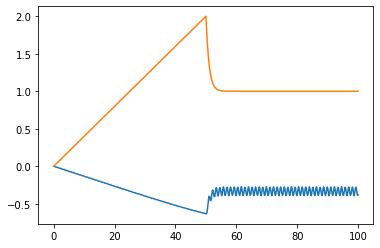

In [51]:
psi_plus=qutip.basis(2,0)
print(psi_plus)

psi_minus=qutip.sigmam()*psi_plus

print(psi_minus)

plt.plot(time,z_exp[:,0])
plt.plot(time,h[:,0])
plt.show()

#### Test for the effective field

Prediction using NNs

(1001, 8)


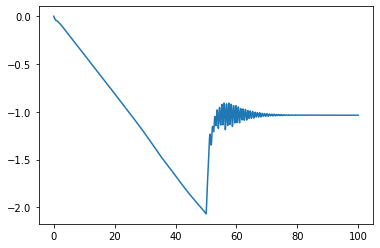

In [52]:
model=torch.load('model_rep/new_analysis_lstm_field2field/LSTM_field2field_xxzx_nonlinear_auxiliary_field_fixed_initial_state_time_steps_100_tf_10_241211_dataset_5k_[500, 500, 500, 500]_hc_[5, 1]_ks_0_ps_4_nconv_1_nblock',map_location='cpu')
model.eval()


input=np.zeros((h.shape[0]+1,h.shape[-1]))
input[1:]=h
input[0]=z_exp[0]
print(input.shape)
input=torch.tensor(input[:,:1]).unsqueeze(0)
h_eff,_=model(input)



h_eff=h_eff[:,1:].squeeze().detach().numpy()

plt.plot(time,h_eff)
plt.show()

Hyperparameters

tf= 100.0
(1000,) (1000,)
(10000,)


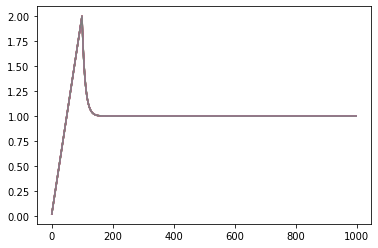

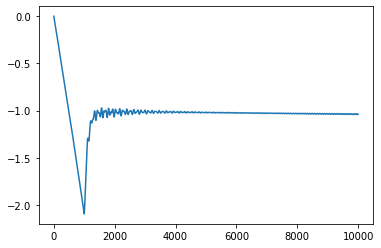

In [47]:
from scipy.interpolate import interp1d
print('tf=',tf)
steps_auxiliary=10000
time_auxiliary=np.linspace(0,tf,steps_auxiliary)
print(time.shape,h_eff.shape)
# interpolate h_eff to step auxiliary to improve the stability of the nonlinear equation
f=interp1d(time,h_eff,axis=0)

h_eff_auxiliary=f(time_auxiliary)

print(h_eff_auxiliary.shape)

plt.plot(h[1:])
plt.show()
plt.plot(h_eff_auxiliary)
plt.show()


Initialize the state

#### Evolution

In [48]:
z_reconstruction=np.zeros((steps_auxiliary,l))
psi=np.zeros((2,l))
psi[0] = np.sqrt((1 + z_exp[0]) / 2)
psi[1] = np.sqrt((1 - z_exp[0]) / 2)
x_op=np.array([[0,1],[1,0]])
z_op=np.array([[1,0],[0,-1]])
dt=time_auxiliary[1]-time_auxiliary[0]
for i in trange(steps_auxiliary):
    psi_r=psi.copy()
    for f in range(1):
        x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
        z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
        
        #pbc
        nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
        
        #obc
        # shift_plus=np.zeros(l)
        # shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
        # shift_minus=np.zeros(l)
        # shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
        #print(shift_minus,shift_plus)
        #nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega
        #h_eff=(0.25*current_derivative[i]/nonlinear_term+z_exp[i]*nonlinear_term)/(x_ave+10**-10)
        #print('heff_shape=',h_eff.shape)
        hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff_auxiliary[i,None,None]*z_op[None,:,:]
        exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
        for r in range(l):
            exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
        #print(exp_h_t)    
        psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
        psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
        
    psi=np.einsum('lab,bl->al',exp_h_t,psi)
    psi=psi/np.linalg.norm(psi,axis=0)
    
    
    z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
    





# reduce z_reconstruction to steps
z_reconstruction=np.array([np.interp(time, time_auxiliary, z_reconstruction[:, i]) for i in range(z_reconstruction.shape[-1])]).T
    


# we need to build up the Auxiliar Time dependent evolution by using Exact diagonalization

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_763234/2154254835.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
100%|██████████| 10000/10000 [00:25<00:00, 388.52it/s]


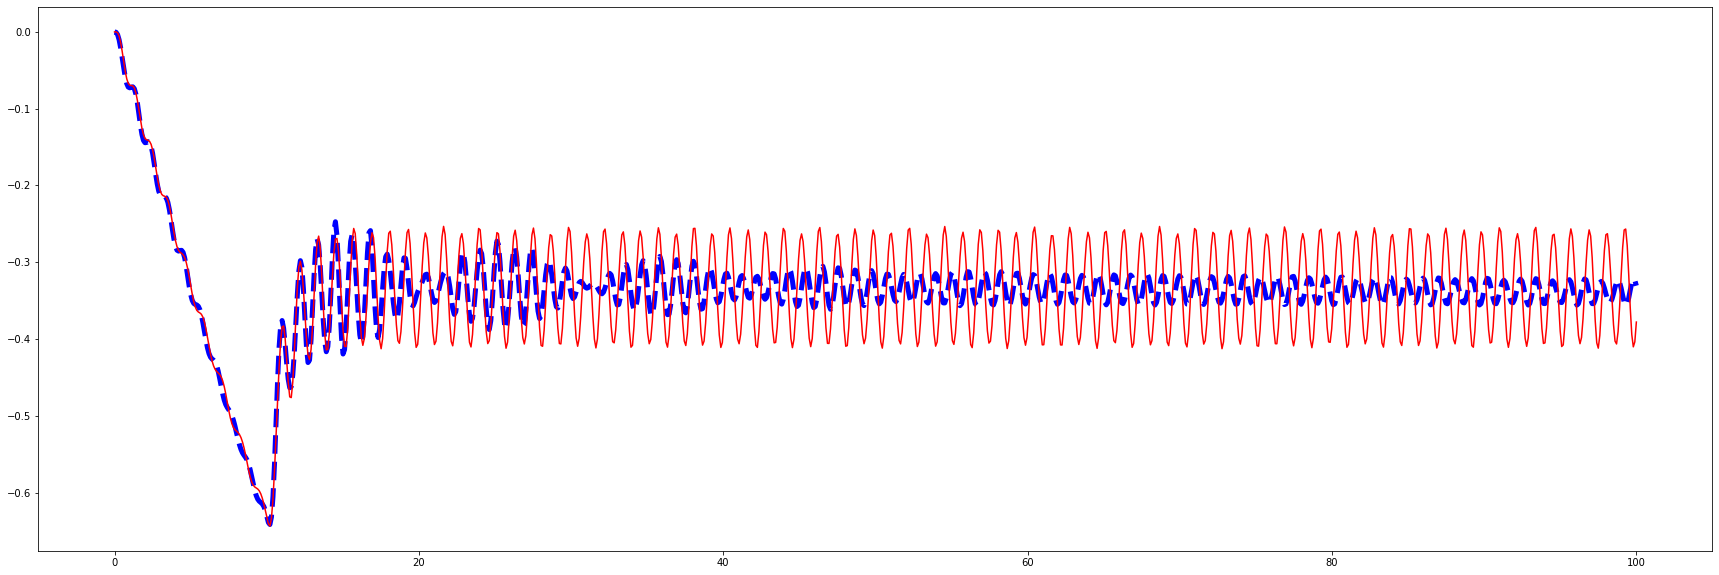

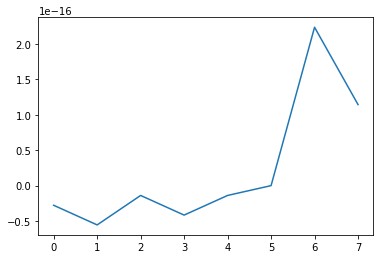

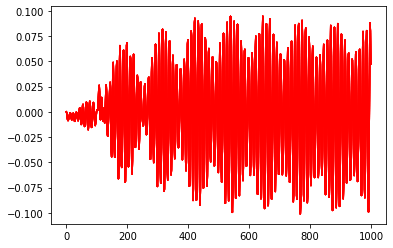

In [49]:
plt.figure(figsize=(30,10))
for i in range(1):
    plt.plot(time,z_reconstruction[:,i],color='blue',linestyle='--',linewidth=5)
    plt.plot(time,z_exp[:,i],color='red')
    #plt.xlim([50,60])
    plt.show()

plt.plot(z_exp[0])
plt.show()

plt.plot(z_reconstruction-z_exp[:,:],color='red')
plt.show()